Import necessary files


In [204]:
import pandas as pd
import numpy as np
from functions import *
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from psycopg2.extras import execute_values



Extraction Layer

In [205]:
# import the csv file
sales_df = pd.read_csv(r'dataset\rawdata\Sales Dataset.csv')

In [206]:
sales_df.info()
sales_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Order ID      1194 non-null   object
 1   Amount        1194 non-null   int64 
 2   Profit        1194 non-null   int64 
 3   Quantity      1194 non-null   int64 
 4   Category      1194 non-null   object
 5   Sub-Category  1194 non-null   object
 6   PaymentMode   1194 non-null   object
 7   Order Date    1194 non-null   object
 8   CustomerName  1194 non-null   object
 9   State         1194 non-null   object
 10  City          1194 non-null   object
 11  Year-Month    1194 non-null   object
dtypes: int64(3), object(9)
memory usage: 70.0+ KB


,Order ID,Amount,Profit,Quantity,Category,Sub-Category,PaymentMode,Order Date,CustomerName,State,City,Year-Month
0,B-26776,9726,1275,5,Electronics,Electronic Games,UPI,2023-06-27,David Padilla,Florida,Miami,2023-06
1,B-26776,9726,1275,5,Electronics,Electronic Games,UPI,2024-12-27,Connor Morgan,Illinois,Chicago,2024-12
2,B-26776,9726,1275,5,Electronics,Electronic Games,UPI,2021-07-25,Robert Stone,New York,Buffalo,2021-07
3,B-26776,4975,1330,14,Electronics,Printers,UPI,2023-06-27,David Padilla,Florida,Miami,2023-06
4,B-26776,4975,1330,14,Electronics,Printers,UPI,2024-12-27,Connor Morgan,Illinois,Chicago,2024-12


### Handle missing Values

In [207]:
# check for null
sales_df.isnull()


,Order ID,Amount,Profit,Quantity,Category,Sub-Category,PaymentMode,Order Date,CustomerName,State,City,Year-Month
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1189,False,False,False,False,False,False,False,False,False,False,False,False
1190,False,False,False,False,False,False,False,False,False,False,False,False
1191,False,False,False,False,False,False,False,False,False,False,False,False
1192,False,False,False,False,False,False,False,False,False,False,False,False


In [208]:
sales_df.columns

Index(['Order ID', 'Amount', 'Profit', 'Quantity', 'Category', 'Sub-Category',
       'PaymentMode', 'Order Date', 'CustomerName', 'State', 'City',
       'Year-Month'],
      dtype='object')

In [209]:
#standardize column names
sales_df = standardize_column_names(sales_df)

sales_df.columns

Index(['order_id', 'amount', 'profit', 'quantity', 'category', 'sub_category',
       'paymentmode', 'order_date', 'customername', 'state', 'city',
       'year_month'],
      dtype='object')

In [210]:
# change date column to date data type
sales_df["order_date"] = pd.to_datetime(sales_df["order_date"])
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_id      1194 non-null   object        
 1   amount        1194 non-null   int64         
 2   profit        1194 non-null   int64         
 3   quantity      1194 non-null   int64         
 4   category      1194 non-null   object        
 5   sub_category  1194 non-null   object        
 6   paymentmode   1194 non-null   object        
 7   order_date    1194 non-null   datetime64[ns]
 8   customername  1194 non-null   object        
 9   state         1194 non-null   object        
 10  city          1194 non-null   object        
 11  year_month    1194 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 74.7+ KB


In [211]:
# remove duplicate 
print(f"total record {len(sales_df)}")
sales_df = sales_df.drop_duplicates()
print(f"total record {len(sales_df)}")

total record 1194
total record 1194


In [212]:
# rename order id column
sales_df = sales_df.rename(columns={'order_id': 'order_no'})
sales_df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1194 entries, 0 to 1193
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_no      1194 non-null   object        
 1   amount        1194 non-null   int64         
 2   profit        1194 non-null   int64         
 3   quantity      1194 non-null   int64         
 4   category      1194 non-null   object        
 5   sub_category  1194 non-null   object        
 6   paymentmode   1194 non-null   object        
 7   order_date    1194 non-null   datetime64[ns]
 8   customername  1194 non-null   object        
 9   state         1194 non-null   object        
 10  city          1194 non-null   object        
 11  year_month    1194 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 84.0+ KB


In [213]:
# create a new order id column 
sales_df = sales_df.reset_index(drop=True)
sales_df['order_id'] = range(1, len(sales_df) + 1)

In [214]:
sales_df.info()
sales_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_no      1194 non-null   object        
 1   amount        1194 non-null   int64         
 2   profit        1194 non-null   int64         
 3   quantity      1194 non-null   int64         
 4   category      1194 non-null   object        
 5   sub_category  1194 non-null   object        
 6   paymentmode   1194 non-null   object        
 7   order_date    1194 non-null   datetime64[ns]
 8   customername  1194 non-null   object        
 9   state         1194 non-null   object        
 10  city          1194 non-null   object        
 11  year_month    1194 non-null   object        
 12  order_id      1194 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(3), object(8)
memory usage: 79.4+ KB


,order_no,amount,profit,quantity,category,sub_category,paymentmode,order_date,customername,state,city,year_month,order_id
0,B-26776,9726,1275,5,Electronics,Electronic Games,UPI,2023-06-27,David Padilla,Florida,Miami,2023-06,1
1,B-26776,9726,1275,5,Electronics,Electronic Games,UPI,2024-12-27,Connor Morgan,Illinois,Chicago,2024-12,2
2,B-26776,9726,1275,5,Electronics,Electronic Games,UPI,2021-07-25,Robert Stone,New York,Buffalo,2021-07,3
3,B-26776,4975,1330,14,Electronics,Printers,UPI,2023-06-27,David Padilla,Florida,Miami,2023-06,4
4,B-26776,4975,1330,14,Electronics,Printers,UPI,2024-12-27,Connor Morgan,Illinois,Chicago,2024-12,5


In [215]:
sales_df.columns

Index(['order_no', 'amount', 'profit', 'quantity', 'category', 'sub_category',
       'paymentmode', 'order_date', 'customername', 'state', 'city',
       'year_month', 'order_id'],
      dtype='object')

In [216]:
# Nomarlization
#customer 
customer_df = sales_df[['customername','city', 'state']].drop_duplicates().reset_index(drop=True)
customer_df['customer_id'] = range(1, len(customer_df) + 1)
customer_df.head()


,customername,city,state,customer_id
0,David Padilla,Miami,Florida,1
1,Connor Morgan,Chicago,Illinois,2
2,Robert Stone,Buffalo,New York,3
3,John Fields,Orlando,Florida,4
4,Clayton Smith,Miami,Florida,5


In [217]:
product_df = sales_df[['category', 'sub_category']].drop_duplicates().reset_index(drop=True)
product_df['product_id'] = range(1, len(product_df) + 1)
product_df.head()

,category,sub_category,product_id
0,Electronics,Electronic Games,1
1,Electronics,Printers,2
2,Office Supplies,Pens,3
3,Electronics,Laptops,4
4,Furniture,Tables,5


In [218]:
payment_df = sales_df[['paymentmode']].drop_duplicates().reset_index(drop=True)
payment_df['payment_id'] = range(1, len(payment_df) + 1)
payment_df.head()

,paymentmode,payment_id
0,UPI,1
1,Debit Card,2
2,EMI,3
3,Credit Card,4
4,COD,5


In [219]:
location_df = sales_df[['city','state']].copy().drop_duplicates().reset_index(drop=True)
location_df['location_id'] = range(1, len(location_df) + 1)
location_df.head()

,city,state,location_id
0,Miami,Florida,1
1,Chicago,Illinois,2
2,Buffalo,New York,3
3,Orlando,Florida,4
4,Los Angeles,California,5


In [220]:
# Merge to build orders sales with foreign keys
order_df = sales_df.merge(customer_df, on=['customername', 'city', 'state']) \
    .merge(product_df, on=['category', 'sub_category']) \
    .merge(payment_df, on=['paymentmode']) \
    .merge(location_df, on=['city', 'state'])

# Add primary key 
order_df = order_df.reset_index(drop=True)
order_df['order_id'] = range(1, len(order_df) + 1)


# Final fact table (OLTP-level)
order_df = order_df[[
    'order_id',  'order_no', 'order_date', 'year_month',
    'customer_id', 'product_id', 'payment_id', 'location_id',
    'amount', 'profit', 'quantity'
]]

# DimCustomer
dim_customer = customer_df[['customer_id', 'customername']].copy()

# DimProduct
dim_product = product_df[['product_id', 'category', 'sub_category']].copy()

# DimPayment
dim_payment = payment_df[['payment_id', 'paymentmode']].copy()

# DimLocation
dim_location = location_df[['location_id', 'city', 'state']].copy()

# DimDate
dim_date = order_df[['order_date']].drop_duplicates().reset_index(drop=True)
dim_date['date_id'] = dim_date.index + 1
dim_date['day'] = dim_date['order_date'].dt.day
dim_date['month'] = dim_date['order_date'].dt.month
dim_date['quarter'] = dim_date['order_date'].dt.quarter
dim_date['year'] = dim_date['order_date'].dt.year
dim_date['day_of_week'] = dim_date['order_date'].dt.day_name()

# FactSales table
fact_sales = order_df.merge(dim_date, on='order_date', how='left')
fact_sales = fact_sales[[
    'order_id', 'customer_id', 'product_id', 'payment_id', 'location_id',
    'date_id', 'quantity', 'amount', 'profit'
]]

display(dim_customer.head(3))
display(dim_product.head(3))
display(dim_location.head(3))
display(dim_payment.head(3))
display(dim_date.head(3))
display(order_df.head(3))
display(fact_sales.head(3))


,customer_id,customername
0,1,David Padilla
1,2,Connor Morgan
2,3,Robert Stone


,product_id,category,sub_category
0,1,Electronics,Electronic Games
1,2,Electronics,Printers
2,3,Office Supplies,Pens


,location_id,city,state
0,1,Miami,Florida
1,2,Chicago,Illinois
2,3,Buffalo,New York


,payment_id,paymentmode
0,1,UPI
1,2,Debit Card
2,3,EMI


,order_date,date_id,day,month,quarter,year,day_of_week
0,2023-06-27,1,27,6,2,2023,Tuesday
1,2025-02-19,2,19,2,1,2025,Wednesday
2,2023-12-13,3,13,12,4,2023,Wednesday


,order_id,order_no,order_date,year_month,customer_id,product_id,payment_id,location_id,amount,profit,quantity
0,1,B-26776,2023-06-27,2023-06,1,1,1,1,9726,1275,5
1,2,B-25714,2025-02-19,2025-02,140,1,1,1,6962,3429,12
2,3,B-26224,2023-12-13,2023-12,262,1,1,1,3953,1776,15


,order_id,customer_id,product_id,payment_id,location_id,date_id,quantity,amount,profit
0,1,1,1,1,1,1,5,9726,1275
1,2,140,1,1,1,2,12,6962,3429
2,3,262,1,1,1,3,15,3953,1776


In [221]:
# save table to csv
customer_df.to_csv(r'dataset/cleandata/customer.csv',index=False)
product_df.to_csv(r'dataset/cleandata/product.csv',index=False)
order_df.to_csv(r'dataset/cleandata/order.csv',index=False)
location_df.to_csv(r'dataset/cleandata/location.csv',index=False)
payment_df.to_csv(r'dataset/cleandata/payment.csv',index=False)

### EDR IMAGE

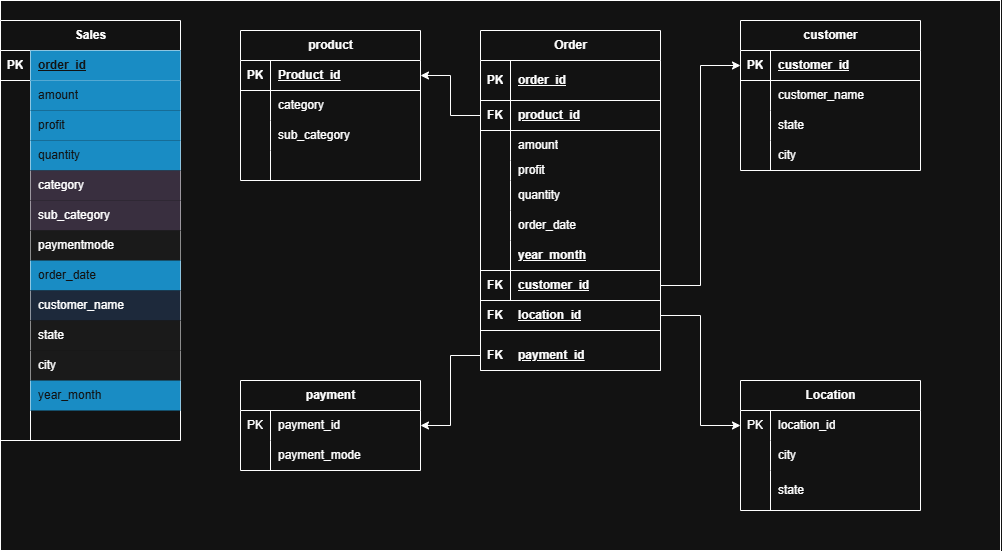

In [222]:
from PIL import Image
img = Image.open('finaledr.png')
img

In [223]:
def create_database(db_params):
    """
    Creates a PostgreSQL database if it does not already exist.
    """
    host, user, password, db_name = db_params

    # Connect to default 'postgres' database
    conn = psycopg2.connect(host=host, user=user, password=password, dbname='postgres')
    conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
    cur = conn.cursor()

    # Check if the database exists
    cur.execute("SELECT 1 FROM pg_database WHERE datname = %s", (db_name,))
    exists = cur.fetchone()

    if exists:
        print(f" Database '{db_name}' already exists.")
    else:
        cur.execute(f"CREATE DATABASE {db_name}")
        print(f"Database '{db_name}' created successfully.")

    cur.close()
    conn.close()

In [224]:
# create db if not exist
db_params = ['localhost', 'postgres', 'admin', 'sales_database']
create_database(db_params)

 Database 'sales_database' already exists.


In [225]:
#function Conntet to the db
def get_db_connection(dbname, user, password, host='localhost', port='5432'):
    try:
        conn = psycopg2.connect(
            dbname=dbname,
            user=user,
            password=password,
            host=host,
            port=port
        )
        print(f"Connected to '{dbname}' as user '{user}'")
        return conn
    except Exception as e:
        print("Connection failed:", e)
        return None


In [226]:
#call the function
conn = get_db_connection(
    dbname="sales_database",
    user="postgres",
    password="admin"
)

Connected to 'sales_database' as user 'postgres'


In [227]:
#functions to create table
from create_all_tables import get_db_connection, create_all_tables
from tables import create_tables_sql

conn = get_db_connection("sales_database", "postgres", "admin")
if conn:
    create_all_tables(conn, create_tables_sql)
    

 Connected to 'sales_database'
All tables created successfully.


### Load data to db

In [228]:
def upsert_from_df(conn, df, table_name, conflict_columns, update_columns=None, schema='public'):
    if df is None or df.empty:
        print(f"Skipping {schema}.{table_name}: DataFrame is empty or None.")
        return

    print(f"Preparing to upsert {len(df)} rows into {schema}.{table_name}...")

    if update_columns is None:
        update_columns = [col for col in df.columns if col not in conflict_columns]

    columns = list(df.columns)
    values = [tuple(x) for x in df.to_numpy()]
    col_names = ', '.join(f'"{col}"' for col in columns)  # safe column naming
    conflict_cols = ', '.join(f'"{col}"' for col in conflict_columns)
    update_stmt = ', '.join([f'"{col}" = EXCLUDED."{col}"' for col in update_columns])

    insert_sql = (
        f'INSERT INTO {schema}.{table_name} ({col_names}) VALUES %s '
        f'ON CONFLICT ({conflict_cols}) DO UPDATE SET {update_stmt};'
    )

    try:
        with conn.cursor() as cur:
            execute_values(cur, insert_sql, values)
        conn.commit()
        print(f"✅ Upserted {len(df)} records into {schema}.{table_name}")
    except Exception as e:
        print(f"❌ Error during upsert: {e}")
        conn.rollback()
from psycopg2.extras import execute_values

def upsert_from_df(conn, df, table_name, conflict_columns, update_columns=None, schema='public'):
    if df is None or df.empty:
        print(f"Skipping {schema}.{table_name}: DataFrame is empty or None.")
        return

    print(f"Preparing to upsert {len(df)} rows into {schema}.{table_name}...")

    if update_columns is None:
        update_columns = [col for col in df.columns if col not in conflict_columns]

    columns = list(df.columns)
    #values = [tuple(x) for x in df.to_numpy()]
    values = [tuple(map(lambda v: v.item() if hasattr(v, 'item') else v, row)) for row in df.to_numpy()]

    col_names = ', '.join(f'"{col}"' for col in columns)  # safe column naming
    conflict_cols = ', '.join(f'"{col}"' for col in conflict_columns)
    update_stmt = ', '.join([f'"{col}" = EXCLUDED."{col}"' for col in update_columns])

    insert_sql = (
        f'INSERT INTO {schema}.{table_name} ({col_names}) VALUES %s '
        f'ON CONFLICT ({conflict_cols}) DO UPDATE SET {update_stmt};'
    )

    try:
        with conn.cursor() as cur:
            execute_values(cur, insert_sql, values)
        conn.commit()
        print(f"✅ Upserted {len(df)} records into {schema}.{table_name}")
    except Exception as e:
        print(f"❌ Error during upsert: {e}")
        conn.rollback()


In [229]:
try:
    upsert_from_df(conn, customer_df, 'customers', ['customer_id'], schema='oltp')
    upsert_from_df(conn, product_df, 'products', ['product_id'], schema='oltp')
    upsert_from_df(conn, payment_df, 'payments', ['payment_id'], schema='oltp')
    upsert_from_df(conn, location_df, 'location', ['location_id'], schema='oltp')
    upsert_from_df(conn, order_df, 'orders', ['order_id'], schema='oltp')

    upsert_from_df(conn, dim_customer, 'dim_customers', ['customer_id'], schema='olap')
    upsert_from_df(conn, dim_product, 'dim_products', ['product_id'], schema='olap')
    upsert_from_df(conn, dim_payment, 'dim_payments', ['payment_id'], schema='olap')
    upsert_from_df(conn, dim_location, 'dim_location', ['location_id'], schema='olap')
    upsert_from_df(conn, dim_date, 'dim_date', ['date_id'], schema='olap')
    upsert_from_df(conn, fact_sales, 'fact_sales', ['order_id'], schema='olap')

    print("All tables successfully uploaded.")
except Exception as e:
    print("Error during table uploads:", e)
    conn.rollback()


Preparing to upsert 807 rows into oltp.customers...
✅ Upserted 807 records into oltp.customers
Preparing to upsert 12 rows into oltp.products...
✅ Upserted 12 records into oltp.products
Preparing to upsert 5 rows into oltp.payments...
✅ Upserted 5 records into oltp.payments
Preparing to upsert 18 rows into oltp.location...
✅ Upserted 18 records into oltp.location
Preparing to upsert 1194 rows into oltp.orders...
✅ Upserted 1194 records into oltp.orders
Preparing to upsert 807 rows into olap.dim_customers...
✅ Upserted 807 records into olap.dim_customers
Preparing to upsert 12 rows into olap.dim_products...
✅ Upserted 12 records into olap.dim_products
Preparing to upsert 5 rows into olap.dim_payments...
✅ Upserted 5 records into olap.dim_payments
Preparing to upsert 18 rows into olap.dim_location...
✅ Upserted 18 records into olap.dim_location
Preparing to upsert 648 rows into olap.dim_date...
✅ Upserted 648 records into olap.dim_date
Preparing to upsert 1194 rows into olap.fact_sales..

### Analytical functions

Profit and loss categorised by city

In [230]:

query = """
SELECT 
    dp.category, 
    dl.city, 
    SUM(fs.amount) AS total_sales, 
    SUM(fs.profit) AS total_profit
FROM olap.fact_sales AS fs
JOIN olap.dim_products AS dp 
    ON fs.product_id = dp.product_id
JOIN olap.dim_location AS dl 
    ON fs.location_id = dl.location_id
GROUP BY dp.category, dl.city
ORDER BY total_profit DESC;

"""

# Step 3: Execute the query and fetch into a DataFrame
df = pd.read_sql_query(query, conn)

# Step 4: Print or save the results
print(df)


           category           city  total_sales  total_profit
0       Electronics        Orlando     165282.0       47715.0
1   Office Supplies        Buffalo     162611.0       44779.0
2       Electronics         Austin     176101.0       43660.0
3   Office Supplies        Orlando     139566.0       43209.0
4   Office Supplies      Rochester     155319.0       42785.0
5       Electronics          Miami     137811.0       42115.0
6       Electronics         Dallas     148326.0       41393.0
7         Furniture  San Francisco     162958.0       41123.0
8         Furniture      San Diego     139091.0       40703.0
9         Furniture        Buffalo     146803.0       39533.0
10  Office Supplies  San Francisco     150269.0       37917.0
11        Furniture        Orlando     147310.0       37201.0
12      Electronics  New York City     125855.0       36347.0
13  Office Supplies    Springfield     178319.0       35713.0
14        Furniture     Cincinnati     124150.0       35327.0
15      

### Highest performing sub category

In [234]:
query = """

SELECT dp.sub_category, ROUND(AVG(fs.profit), 2) AS avg_profit
FROM olap.fact_sales fs
JOIN olap.dim_products dp ON fs.product_id = dp.product_id
GROUP BY dp.sub_category
ORDER BY avg_profit DESC
LIMIT 10;

"""

# Step 3: Execute query and load result into a DataFrame
df = pd.read_sql_query(query, conn)

# Step 4: Print or process the result
print(df)

       sub_category  avg_profit
0           Markers     1588.63
1          Printers     1539.57
2            Chairs     1480.63
3             Paper     1439.64
4  Electronic Games     1427.44
5           Binders     1369.82
6         Bookcases     1340.91
7            Tables     1285.21
8             Sofas     1253.11
9           Laptops     1252.95


### month with highest sales

In [235]:
query = """

SELECT dd.year, dd.month, SUM(fs.amount) AS total_sales
FROM olap.fact_sales fs
JOIN olap.dim_date dd ON fs.date_id = dd.date_id
GROUP BY dd.year, dd.month
ORDER BY dd.year, dd.month;

"""

# Step 3: Execute query and load result into a DataFrame
df = pd.read_sql_query(query, conn)

# Step 4: Print or process the result
print(df)

    year  month  total_sales
0   2020      3      22991.0
1   2020      4     133385.0
2   2020      5     113287.0
3   2020      6      46900.0
4   2020      7      38556.0
..   ...    ...          ...
56  2024     11      60976.0
57  2024     12      98879.0
58  2025      1     112906.0
59  2025      2      84712.0
60  2025      3      52198.0

[61 rows x 3 columns]


Average monthly sales per product

In [237]:
query = """
SELECT dp.product_id, dp.sub_category, ROUND(AVG(fs.amount), 2) AS avg_monthly_sales
FROM olap.fact_sales fs
JOIN olap.dim_products dp ON fs.product_id = dp.product_id
JOIN olap.dim_date dd ON fs.date_id = dd.date_id
GROUP BY dp.product_id, dp.sub_category
ORDER BY avg_monthly_sales DESC;
"""

# Step 3: Execute query and load result into a DataFrame
df = pd.read_sql_query(query, conn)

# Step 4: Print or process the result
print(df)

    product_id      sub_category  avg_monthly_sales
0            2          Printers            5961.67
1            7           Markers            5707.95
2            1  Electronic Games            5433.58
3           10           Binders            5417.06
4            6            Chairs            5204.39
5            5            Tables            5124.40
6            9             Paper            5045.72
7            8             Sofas            4985.68
8           11            Phones            4980.74
9            3              Pens            4844.46
10           4           Laptops            4772.16
11          12         Bookcases            4695.06


In [ ]:
conn.close()